In [43]:
%matplotlib inline

In [ ]:
!pip install fastai==2.2.5

In [3]:
from fastai.vision.all import *

In [4]:
path = Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m')

In [5]:
path.ls()

(#112) [Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/README.md'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/data.csv'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_4941_19960909'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_4942_19970222'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_4943_20000902'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_4944_20010208'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_5393_19990606'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_5395_19981004'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_5396_20010302'),Path('/content/drive/MyDrive/Kaggle/data/kaggle_3m/TCGA_CS_5397_20010315')...]

In [6]:
fname = get_image_files(path)

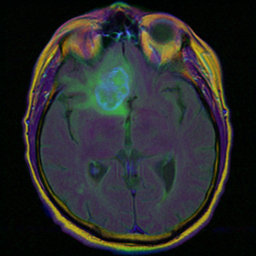

In [7]:
img = PILImage.create(fname[1])
img

In [8]:
def get_mask(o) : return o.parent / f'{o.stem}_mask{o.suffix}'

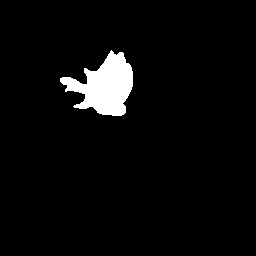

In [ ]:
img_mask = PILMask.create(get_mask(fname[1]))
img_mask

In [9]:
def get_files(o):
  x = L()
  fnames = get_image_files(o)
  for fn in fnames:
    if not fn.match('*mask.tif'):
      x.append(fn)
  return x

In [21]:
codes = ['N', 'Y']

In [18]:
def get_dls(sz,bs):
  dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                   get_items=get_files,
                   splitter=RandomSplitter(seed=42),
                   get_y=get_mask,
                   item_tfms = [ToTensor],
                   batch_tfms=[IntToFloatTensor(div_mask=255.0),*aug_transforms(size=sz,max_warp=0.0), Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path, bs=bs)
  dls.vocab = codes
  return dls

In [ ]:
dls = get_dls(112, 64)

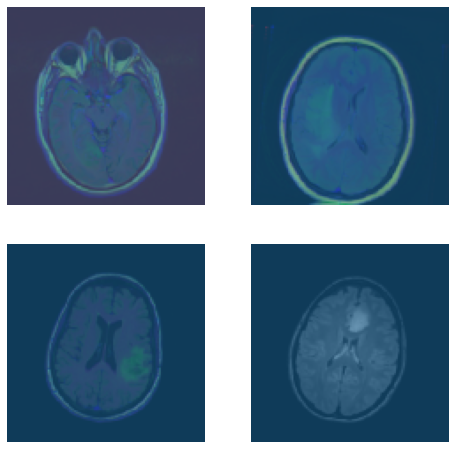

In [ ]:
dls.train.show_batch(max_n=4, figsize=(8,8))

# Experiments

In [ ]:
learn = unet_learner(dls, resnet34, metrics=Dice(), loss_func=CrossEntropyLossFlat(axis=1))

SuggestedLRs(lr_min=0.33113112449646, lr_steep=5.248074739938602e-05)

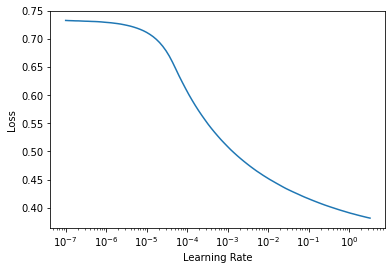

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, base_lr=3e-3)

epoch,train_loss,valid_loss,dice,time
0,0.075196,0.022904,0.457888,00:33


epoch,train_loss,valid_loss,dice,time
0,0.018825,0.011767,0.771326,00:34
1,0.016017,0.010558,0.798198,00:34
2,0.011649,0.008365,0.836991,00:34
3,0.009264,0.007943,0.847263,00:34


SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=7.585775847473997e-07)

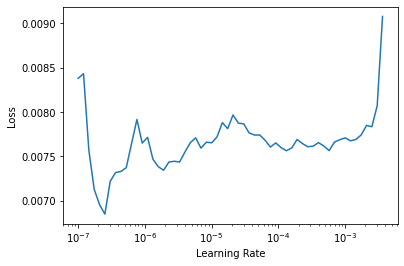

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.save('stage-1')
learn.load('stage-1')

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(6e-4,6e-5))

epoch,train_loss,valid_loss,dice,time
0,0.007801,0.008332,0.844585,00:33
1,0.007834,0.007525,0.858669,00:34
2,0.007207,0.006783,0.868744,00:34
3,0.006538,0.006352,0.876496,00:34
4,0.006113,0.006357,0.876424,00:34


In [ ]:
learn.load('stage-1')
learn.fit_one_cycle(10, lr_max=slice(6e-4,6e-5), wd=1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.007584,0.007447,0.858056,00:33
1,0.007506,0.008291,0.846694,00:34
2,0.007725,0.007272,0.864135,00:34
3,0.006913,0.006862,0.868502,00:34
4,0.006493,0.006348,0.876231,00:34
5,0.006085,0.006325,0.877049,00:34
6,0.005695,0.006202,0.880118,00:34
7,0.005435,0.006078,0.880224,00:34
8,0.005314,0.006060,0.881667,00:34
9,0.005250,0.006069,0.881406,00:34


In [ ]:
learn.export('exp1')

In [ ]:
opt_func = ranger
act_cls = Mish
loss_func = CrossEntropyLossFlat(axis=1)
learn = unet_learner(dls, resnet34, loss_func=loss_func, opt_func=opt_func, act_cls=act_cls, metrics=Dice())

In [ ]:
learn.summary()

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0002754228771664202)

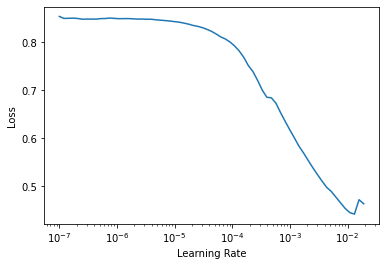

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos??

In [ ]:
learn.fit_flat_cos(5, lr=3e-3)

epoch,train_loss,valid_loss,dice,time
0,0.091610,0.028934,0.425106,00:37
1,0.039629,0.017224,0.643916,00:37
2,0.021582,0.010792,0.804852,00:38
3,0.013748,0.009405,0.825634,00:38
4,0.010270,0.007934,0.844921,00:38


In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=2.75422871709452e-06)

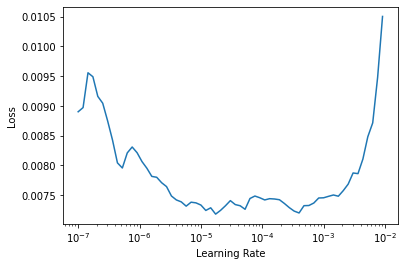

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(15, lr=slice(2e-6, 3e-4), wd=1e-2, cbs=[SaveModelCallback(fname='stage2'), ReduceLROnPlateau(patience=2, factor=3)])

epoch,train_loss,valid_loss,dice,time
0,0.007291,0.007553,0.852430,00:37
1,0.007107,0.007447,0.854333,00:38
2,0.006901,0.007199,0.857461,00:39
3,0.006604,0.007744,0.839148,00:38
4,0.006512,0.006754,0.869164,00:39
5,0.006164,0.006855,0.867580,00:39
6,0.005979,0.006519,0.873429,00:39
7,0.005820,0.006672,0.870401,00:38
8,0.005641,0.006721,0.876268,00:38
9,0.005438,0.006300,0.877927,00:39


Better model found at epoch 0 with valid_loss value: 0.007552776951342821.
Better model found at epoch 1 with valid_loss value: 0.007446546107530594.
Better model found at epoch 2 with valid_loss value: 0.007199151441454887.
Better model found at epoch 4 with valid_loss value: 0.006754089146852493.
Better model found at epoch 6 with valid_loss value: 0.006519431248307228.
Epoch 8: reducing lr to 9.999999999999999e-05
Better model found at epoch 9 with valid_loss value: 0.006299594882875681.
Better model found at epoch 11 with valid_loss value: 0.006002593785524368.
Better model found at epoch 13 with valid_loss value: 0.005940728355199099.


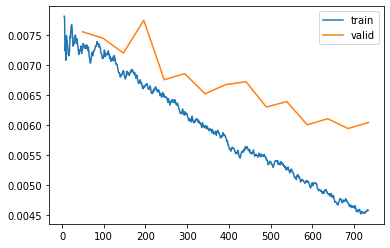

In [ ]:
learn.recorder.plot_loss()

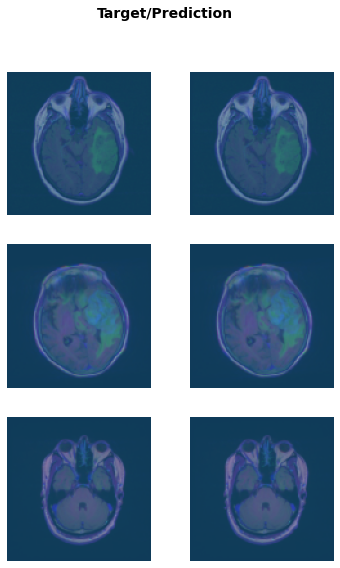

In [ ]:
learn.recorder.show_results()

In [ ]:
learn.dls = get_dls(244, 16)

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=5.754399353463668e-06)

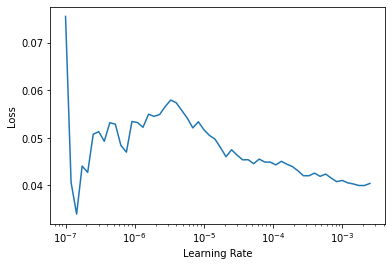

In [ ]:
learn.lr_find()

In [ ]:
learn.freeze()

In [ ]:
learn.fit_flat_cos(5, lr=2e-4, wd=1e-2, cbs=[SaveModelCallback(fname='stage3')])

epoch,train_loss,valid_loss,dice,time
0,0.011126,0.007634,0.852362,03:01
1,0.008775,0.006916,0.870999,03:00
2,0.006256,0.006354,0.882387,03:00
3,0.006111,0.005924,0.887492,03:00
4,0.005435,0.005722,0.889917,03:00


Better model found at epoch 0 with valid_loss value: 0.007634326349943876.
Better model found at epoch 1 with valid_loss value: 0.006916490383446217.
Better model found at epoch 2 with valid_loss value: 0.006354272831231356.
Better model found at epoch 3 with valid_loss value: 0.0059236022643744946.
Better model found at epoch 4 with valid_loss value: 0.005721923895180225.


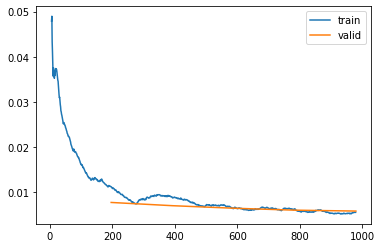

In [ ]:
learn.recorder.plot_loss()

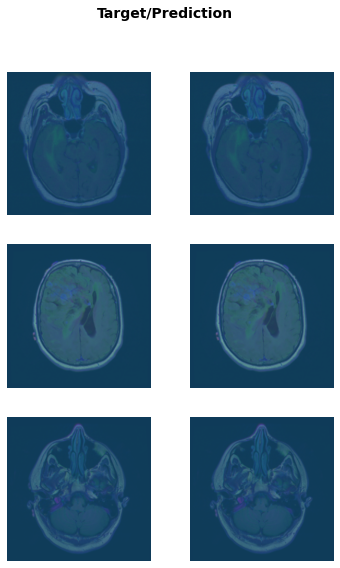

In [ ]:
learn.recorder.show_results()

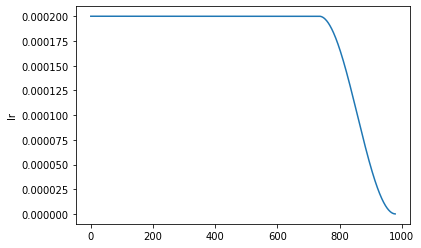

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.export('exp2')

In [12]:
learn = load_learner(path.parent.parent/'exp2')

In [50]:
a_data_path = path/'TCGA_HT_7694_19950404'
img_files = get_files(a_data_path)

In [57]:
def plot_images():
  fig, ax = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)
  for i in range(3):
    img = PILImage.create(img_files[i+2])
    img_mask = PILMask.create(get_mask(img_files[i+2]))
    pred_mask = PILMask.create(learn.predict(img)[0])
    ax[i][0].imshow(img)
    ax[i][0].set_title('MRI Scans')

    ax[i][1].imshow(img_mask)
    ax[i][1].set_title('Target')

    ax[i][2].imshow(pred_mask)
    ax[i][2].set_title('Predicted')

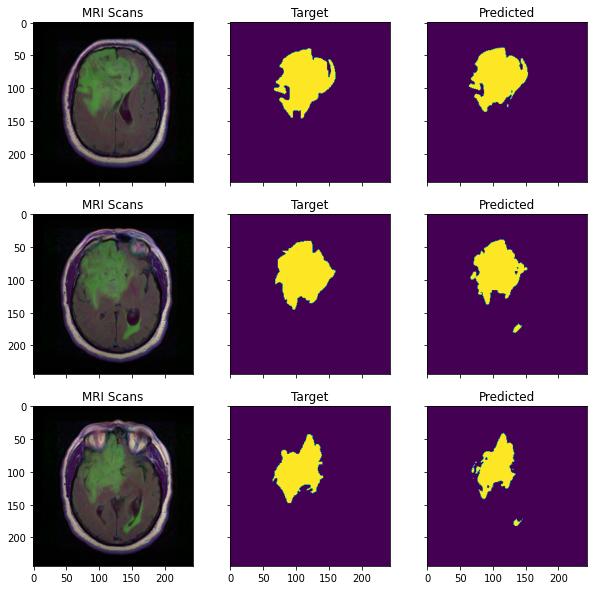

In [58]:
plot_images()